### Recap

By this point, I've added all the features I'm willing to add for this project. To save myself time in the future, I've saved my updates in a new CSV file.

In [1]:
import pandas as pd
import numpy as np
from IPython.display import Image
from sklearn.model_selection import train_test_split

import stackoverflow_helper as soh
import dictionaries as look

In [2]:
raw_import = pd.read_csv('/Users/pang/repos/stack-overflow-survey/_data/output', index_col='Respondent')

For future reference, this is how I can call the functions to get that dataset back:

```
other_imports = look.multi_select_fields + ['Age', 'ConvertedComp', 'WorkWeekHrs', 'CodeRevHrs', 'Country', 'ScreenName']
df_big = soh.get_analysis_data(raw_import, other_imports)
df_big.to_csv('/Users/pang/repos/stack-overflow-survey/_data/output')
```

And as before, we break up the rows as before:

In [13]:
y_big = raw_import['JobSat']
X_big = raw_import.drop(columns='JobSat')
X_train_big, X_test_final, y_train_big, y_test_final = train_test_split(
    X_big, y_big, test_size=0.20, random_state=4444)

y = y_train_big
X = X_train_big
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=4444)
df = pd.DataFrame(y_train).merge(X_train, on='Respondent')
df_te = pd.DataFrame(y_test).merge(X_test, on='Respondent')

And as a reminder, below are the baselines we got from notebook 1

| Metrics | K Nearest Neighbor | Logistic Regression | Gaussian Naive Bayes | Support Vector Machine | Decision Tree | Random Forest | 
| ----: | :----: | :----: | :----: | :----: | :----: | :----: |
| **Accuracy** | 0.595220 | 0.661384 | 0.661384 | 0.661384 | 0.610965 | 0.619717 |
| **Precision** | 0.694881 | 0.661384 | 0.661384 | 0.661384 | 0.704984 | 0.698451 |
| **Recall** | 0.819655 | 1.000000 | 1.000000 | 1.000000 | 0.923297 | 0.937549 | 
| **F1** | 0.752129 | 0.796184 | 0.796184 | 0.796184 | 0.799505 | 0.800528 | 

Below are baselines for notebook 2. While they're generally worse, we're hoping that feature engineering, the addition of new features and parameter tuning will outpace the naive implementations above:

| Metrics | K Nearest Neighbor | Logistic Regression | Gaussian Naive Bayes | Support Vector Machine | Decision Tree | Random Forest | 
| ----: | :----: | :----: | :----: | :----: | :----: | :----: |
| **Accuracy** | 0.591140 | 0.660813 | 0.659794 | 0.660813 | 0.625805 | 0.670328 |
| **Precision** | 0.673712 | 0.660813 | 0.661792 | 0.660813 | 0.711064 | 0.734383 |
| **Recall** | 0.786902 | 1.000000 | 0.985256 | 1.000000 | 0.697411 | 0.775930 | 
| **F1** | 0.725921 | 0.795771 | 0.791761 | 0.795771 | 0.704172 | 0.754585 | 

After adding the rest of the features (between notebook 2 and 3), the new metrics are mix:

| Metrics | K Nearest Neighbor | Logistic Regression | Gaussian Naive Bayes | Support Vector Machine | Decision Tree | Random Forest | 
| ----: | :----: | :----: | :----: | :----: | :----: | :----: |
| **Accuracy** | 0.594991 | 0.660813 | 0.660587	| 0.660813 | 0.621052 | 0.667045 |
| **Precision** | 0.676204 | 0.660813 | 0.662423 | 0.660813 | 0.718215 | 0.728230 |
| **Recall** | 	0.794103 | 1.000000 | 0.981313 | 1.000000 | 0.711812 | 0.794274 | 
| **F1** | 	0.730427 | 0.795771 | 0.790935 | 0.795771 | 0.714999 | 0.759820 |

However, Random Forest continues to outperform when reviewing ROC curves and ROC AUC metrics so I will see what I can do to improve this particular model's performance.

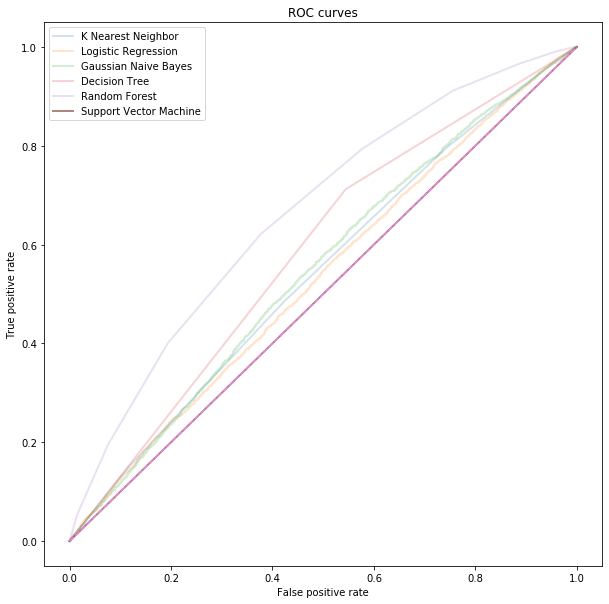

In [4]:
Image('/Users/pang/repos/stack-overflow-survey/_data/note3_roc.png')

ROC AUC scores:
```
ROC AUC score of K Nearest Neighbor is: 0.5423660052260645
ROC AUC score of Logistic Regression is: 0.5326333563177559
ROC AUC score of Gaussian Naive Bayes is: 0.5479847631716945
ROC AUC score of Decision Tree is: 0.5838619635980344
ROC AUC score of Random Forest is: 0.6651675257481074
ROC AUC score of Support Vector Machine is: 0.5
```

### Parameter tuning

To start, let's see what gains we can get by modifying the parameters starting with n_estimators.

For our setup, we just have a function that will quickly let us iterate through various parameters of interest:

In [36]:
import matplotlib.pyplot as plt

In [32]:
def do_the_thing(n_estimators=10, criterion='gini', max_depth=None,
                 min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0,
                 max_features='auto', max_leaf_nodes=None):
    rfc = RandomForestClassifier(n_estimators, criterion, max_depth,
                 min_samples_split, min_samples_leaf, min_weight_fraction_leaf,
                 max_features, max_leaf_nodes)
    rfc.fit(X_train, y_train)
    
    roc_auc_score = cross_val_score(rfc, X_test, y_test, cv=5, scoring='roc_auc')
    return roc_auc_score.mean()

**N-estimators and criterion**

In [45]:
scores_g = []

for n in range(1,110):
    score = do_the_thing(n_estimators=n)
    scores_g.append(score)

In [48]:
scores_e = []

for n in range(1,110):
    score = do_the_thing(n_estimators=n, criterion='entropy')
    scores_e.append(score)

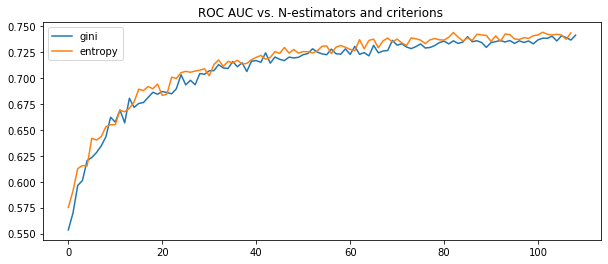

In [72]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))  

plt.title('ROC AUC vs. N-estimators and criterions')
plt.plot(scores_g, label='gini')
plt.plot(scores_e, label='entropy')

plt.legend();

**Max Depth**

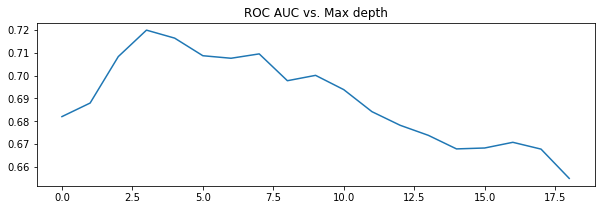

In [79]:
scores_md = []

for md in range(1,20):
    score = do_the_thing(max_depth=md)
    scores_md.append(score)

fig, ax = plt.subplots(1, 1, figsize=(10, 3))  

plt.title('ROC AUC vs. Max depth')
plt.plot(scores_md);

**Minimum number of samples required to be at a leaf node**

In [85]:
scores_msl = []

for msl in range(1,40):
    score = do_the_thing(min_samples_leaf=msl)
    scores_msl.append(score)

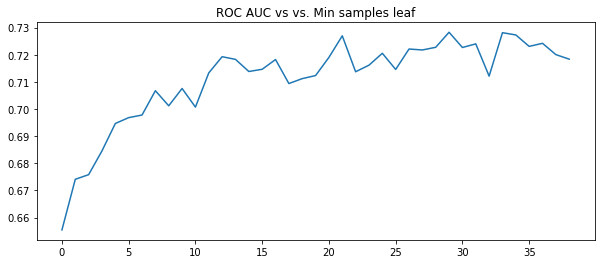

In [88]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))  

plt.title('ROC AUC vs vs. Min samples leaf')
plt.plot(scores_msl);

Based on the above data, we will choose the following parameters:

- criterion: entropy (seems to generally be higher than gini)
- n-estimators: 35 (while higher might get us slightly better numbers, the time to calculate is large)
- max_depth: 7
- min_samples_leaf: 23